In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense


2025-04-19 23:00:15.373175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745103615.626156      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745103615.703014      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Read Data


In [2]:
df = pd.read_csv("/kaggle/input/proj-mta-daily-depi/MTA_Daily_Ridership (1).csv")


# Data Preprocessing

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df = df.sort_values('Date')

# نختار العمود اللي عاوزين نتنبأ بيه
data = df[['Subways: Total Estimated Ridership']].dropna()


In [5]:
df.head(5)

,Date,Subways: Total Estimated Ridership,Subways: % of Comparable Pre-Pandemic Day,Buses: Total Estimated Ridership,Buses: % of Comparable Pre-Pandemic Day,LIRR: Total Estimated Ridership,LIRR: % of Comparable Pre-Pandemic Day,Metro-North: Total Estimated Ridership,Metro-North: % of Comparable Pre-Pandemic Day,Access-A-Ride: Total Scheduled Trips,Access-A-Ride: % of Comparable Pre-Pandemic Day,Bridges and Tunnels: Total Traffic,Bridges and Tunnels: % of Comparable Pre-Pandemic Day,Staten Island Railway: Total Estimated Ridership,Staten Island Railway: % of Comparable Pre-Pandemic Day
0,2020-03-01,2212965,97,984908,99,86790,100,55825,59,19922,113,786960,98,1636,52
1,2020-03-02,5329915,96,2209066,99,321569,103,180701,66,30338,102,874619,95,17140,107
2,2020-03-03,5481103,98,2228608,99,319727,102,190648,69,32767,110,882175,96,17453,109
3,2020-03-04,5498809,99,2177165,97,311662,99,192689,70,34297,115,905558,98,17136,107
4,2020-03-05,5496453,99,2244515,100,307597,98,194386,70,33209,112,929298,101,17203,108


# Feature Scaling

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


# 

# Create Sequences

In [7]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)


In [8]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# GRU (Model Architecture)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()


model.add(GRU(128, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(1))


model.compile(optimizer='adam', loss='mse') 


I0000 00:00:1745103629.075761      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745103629.076510      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


I0000 00:00:1745103634.729401      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.0533 - val_loss: 0.0653
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4121 - val_loss: 0.0562
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3154 - val_loss: 0.0574
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2440 - val_loss: 0.0571
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2462 - val_loss: 0.0655
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2142 - val_loss: 0.0671
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1738 - val_loss: 0.0640
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1312 - val_loss: 0.0573
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1281 - val_loss: 0.0455
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1110 - val_loss: 0.0323
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0942 - val_loss: 0.0268
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0808 - val_

# Prediction

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


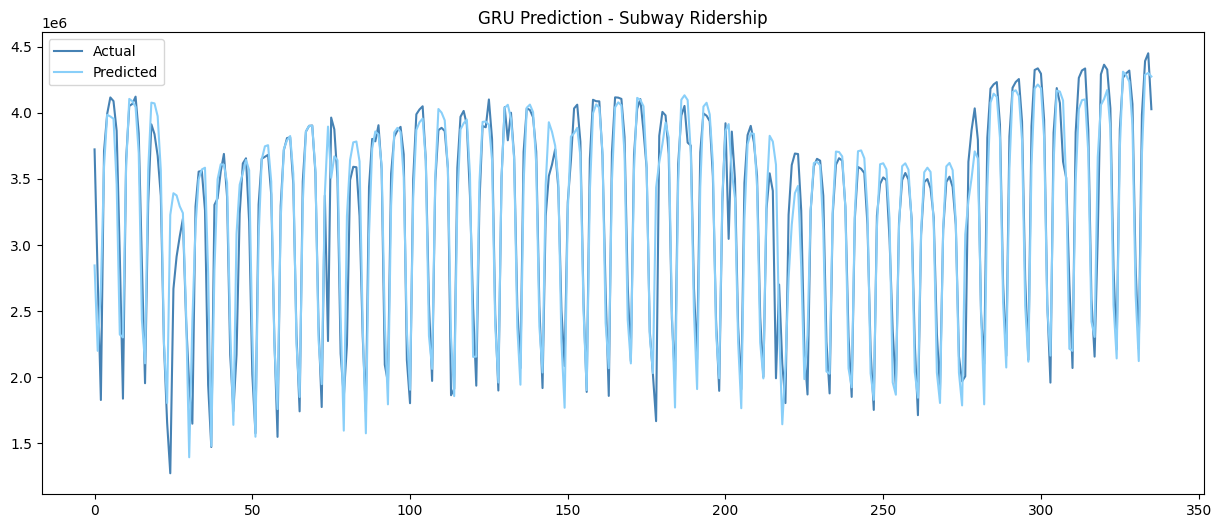

In [12]:
y_pred = model.predict(X_test)
#عشان ارجع النتائج لاصلها بدل 0و1
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

plt.figure(figsize=(15,6))
plt.plot(y_test_inv,color='#4682B4',label="Actual")
plt.plot(y_pred_inv,color='#89CFF9', label="Predicted")
plt.legend()
plt.title("GRU Prediction - Subway Ridership")
plt.show()
